### 02_LimpiezaEDA.ipynb:
Este notebook se centra en la limpieza de datos, el análisis exploratorio (EDA) y la ingeniería de características. Se prepararán los datos para el modelado.

Limpieza: Se manejarán valores faltantes, se eliminarán duplicados y se tratarán posibles valores atípicos. Por ejemplo, se imputarán los valores faltantes en las columnas "Issue", "State", "ZIP code" y "Consumer disputed?".

Feature Engineering: Se crearán nuevas variables a partir de las existentes. Una idea es crear una variable que represente el tiempo en días que tarda una compañía en responder a una queja, calculada a partir de las columnas Date received y Date sent to company. También se podrían agrupar algunas compañías con un número bajo de quejas en una categoría "Otros" para reducir la cardinalidad.
Transformaciones y limpiezas, así como visualizaciones dentro de un análisis exploratiorio.

EDA: Se analizará la distribución de las quejas por producto (Product), estado (State) y compañía (Company). Se visualizará la relación entre la variable objetivo Consumer disputed? y otras variables.

In [1]:
# Importamos librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

# Ignoramos los warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
path_data = "C:/Users/aisat/Desktop/DSPT25_RA/3-DSPT2025-ML/Proy_Final_ML_RA/data/"
path_img = "C:/Users/aisat/Desktop/DSPT25_RA/3-DSPT2025-ML/Proy_Final_ML_RA/img/"

In [3]:
# Cargamos los dataframe "df" y "df_zip":
df = pd.read_csv(path_data + 'df.csv', encoding='utf-8')
df_zip = pd.read_csv(path_data + 'df_zip.csv', encoding='utf-8')

In [4]:
# Un pequeño reporte de las columnas, con sus tipos, % de missings y cardinalidad, resultará muy útil a lo largo de la analítica.
def data_report(df):
    # Sacamos los NOMBRES
    cols = pd.DataFrame(df.columns.values, columns=["COL_N"])

    # Sacamos los TIPOS
    types = pd.DataFrame(df.dtypes.values, columns=["DATA_TYPE"])

    # Sacamos los MISSINGS
    percent_missing = round(df.isnull().sum() * 100 / len(df), 2)
    percent_missing_df = pd.DataFrame(percent_missing.values, columns=["MISSINGS (%)"])

    # Sacamos los VALORES UNICOS
    unicos = pd.DataFrame(df.nunique().values, columns=["UNIQUE_VALUES"])
    
    percent_cardin = round(unicos['UNIQUE_VALUES']*100/len(df), 2)
    percent_cardin_df = pd.DataFrame(percent_cardin.values, columns=["CARDIN (%)"])

    concatenado = pd.concat([cols, types, percent_missing_df, unicos, percent_cardin_df], axis=1, sort=False)
    concatenado.set_index('COL_N', drop=True, inplace=True)

    return concatenado.T
        
data_report(df)

COL_N,Unnamed: 0,Complaint ID,Product,Sub-product,Issue,Sub-issue,State,ZIP code,Date received,Date sent to company,Company,Company response,Timely response?,Consumer disputed?
DATA_TYPE,int64,int64,object,object,object,object,object,float64,object,object,object,object,object,object
MISSINGS (%),0.0,0.0,0.0,37.56,0.01,53.08,1.5,0.99,0.0,0.0,0.0,0.0,0.0,78.67
UNIQUE_VALUES,28156,28156,11,42,89,46,59,9868,78,78,1534,6,2,2
CARDIN (%),100.0,100.0,0.04,0.15,0.32,0.16,0.21,35.05,0.28,0.28,5.45,0.02,0.01,0.01


Analizamos los elementos más frecuentes de las diferentes columnas/variables numéricas y categóricas.

In [5]:
# Crearemos un informe para cada variable del dataframe, ordenados de forma descendente y %, número de valores unicos y datos faltantes.
def variable_report(df):
    for variable in df.columns:
        columna_original = variable
        # 1. Obtener la frecuencia de cada elemento único y ordenar de forma descendente
        conteo_elementos = df[columna_original].value_counts()

        # 2. Calcular el porcentaje de cada elemento
        porcentaje = df[columna_original].value_counts(normalize=True) * 100

        # 3. Formatear el porcentaje a 2 decimales
        porcentaje_formateado = porcentaje.map('{:.2f}%'.format)

        # 4. Crear un nuevo DataFrame con la información
        df_resultado = pd.DataFrame({
            columna_original: conteo_elementos.index,
            'Frecuencia': conteo_elementos.values,
            'Porcentaje': porcentaje_formateado.values
        })
        print (df_resultado.head(12), "\n")
        print ("Número de datos únicos", len(df[columna_original].sort_values(ascending=True).unique()))
        print ("Número de datos faltantes", len(df[df[columna_original].isna()]),"\n", "-" * 50)
        

In [6]:
variable_report(df)

    Unnamed: 0  Frecuencia Porcentaje
0        28155           1      0.00%
1            0           1      0.00%
2            1           1      0.00%
3            2           1      0.00%
4            3           1      0.00%
5            4           1      0.00%
6            5           1      0.00%
7            6           1      0.00%
8            7           1      0.00%
9            8           1      0.00%
10           9           1      0.00%
11          10           1      0.00% 

Número de datos únicos 28156
Número de datos faltantes 0 
 --------------------------------------------------
    Complaint ID  Frecuencia Porcentaje
0        1178180           1      0.00%
1        1291006           1      0.00%
2        1290580           1      0.00%
3        1290564           1      0.00%
4        1291615           1      0.00%
5        1292165           1      0.00%
6        1291176           1      0.00%
7        1288848           1      0.00%
8        1288788           1      

In [7]:
# Creamos una copia de nuestro dataframe
datacopy = df.copy()

### Analisis preliminar de Features.
En ocasiones es casi imposible llevar a cabo un análisis exploratorio si tenemos una gran cantidad de features, básicamente lo que haremos es eliminar algunas features:
1. **Muchos missings**: a partir de un 40% de missings son features dificilmente salvables.
2. **Features repetidas**: columnas repetidas. Asegúrate bien de que sea así.
3. **Identificadores**: ids, nombres únicos. Son features que no aportan nada.

4. **Feature selection**: Para seleccionar las mejores variables en un modelo de machine learning, cuando tienes datos numéricos y categóricos, se utilizan diferentes métodos. Estos métodos se pueden agrupar en tres categorías principales:
 - **Filtros** (filter methods): Correlación Pearson y ANOVA (Var_Num); Chi-cuadrado ($χ^2$) en (Var_Cat); Correlación PhiK e Inform Mutua (Var_Mix). 
 - **Envolventes** (wrapper methods): Se prueban diferentes combinaciones de variables y se elige la que produce el mejor rendimiento para el modelo. Forward Selection; Backward Elimination; Recursive Feature Elimination (RFE).
 - **Embebidos** (embedded methods): Estos métodos combinan las mejores propiedades de los métodos de filtro y envolventes. Regularización L1 (Lasso); Regularización L2 (Ridge); Árboles de Decisión (Decision Trees) y Bosques Aleatorios (Random Forests). Son muy potentes porque pueden manejar ambos tipos de datos (numéricos y categóricos) sin necesidad de preprocesamiento complejo para la selección.
     
Estas técnicas son muy útiles por dos motivos:
* Comprender qué variables han influenciado más en la predicción del target
* Ver cuáles son las variables que tienen mayor relación con el target antes de correr cualquier modelo. Esto nos puede servir para hacer una primera preselección.

**Vamos ha utilizar las recomendaciones y los metodos de "Feature selection" que mejor se adapten a nuestro DataFrame, para decidir de forma más eficiente que columnas eliminar o como gestionarlas.**

**MISSINGS**

Suponen un problema ya que la mayoría de los modelos no saben tratar los missings y por tanto tendremos que eliminarlos o inferir sus valores.

In [8]:
# Vemos porcentajes de los Datos faltantes.
precent_missing = datacopy.isnull().sum()*100/len(datacopy)
missing_value_datacopy = pd.DataFrame({'column_name': datacopy.columns,
                                'percent_missing': precent_missing}).sort_values('percent_missing', ascending=False)
missing_value_datacopy

,column_name,percent_missing
Consumer disputed?,Consumer disputed?,78.668845
Sub-issue,Sub-issue,53.079273
Sub-product,Sub-product,37.555050
State,State,1.495241
ZIP code,ZIP code,0.994459
Issue,Issue,0.007103
Product,Product,0.000000
Complaint ID,Complaint ID,0.000000
Unnamed: 0,Unnamed: 0,0.000000
Date received,Date received,0.000000


**CORRELACIÓN**

Phik ( 𝜙 k) es un coeficiente de correlación práctico que funciona de manera consistente entre variables categóricas, ordinales y de intervalo.
Captura la dependencia no lineal y revierte al coeficiente de correlación de Pearson en el caso de una distribución de entrada normal bivariada.
Esta matriz es un muy buen indicador sobre la relación entre los datos, teniendo en cuenta variables categóricas.

interval columns not set, guessing: ['Unnamed: 0', 'Complaint ID', 'ZIP code']


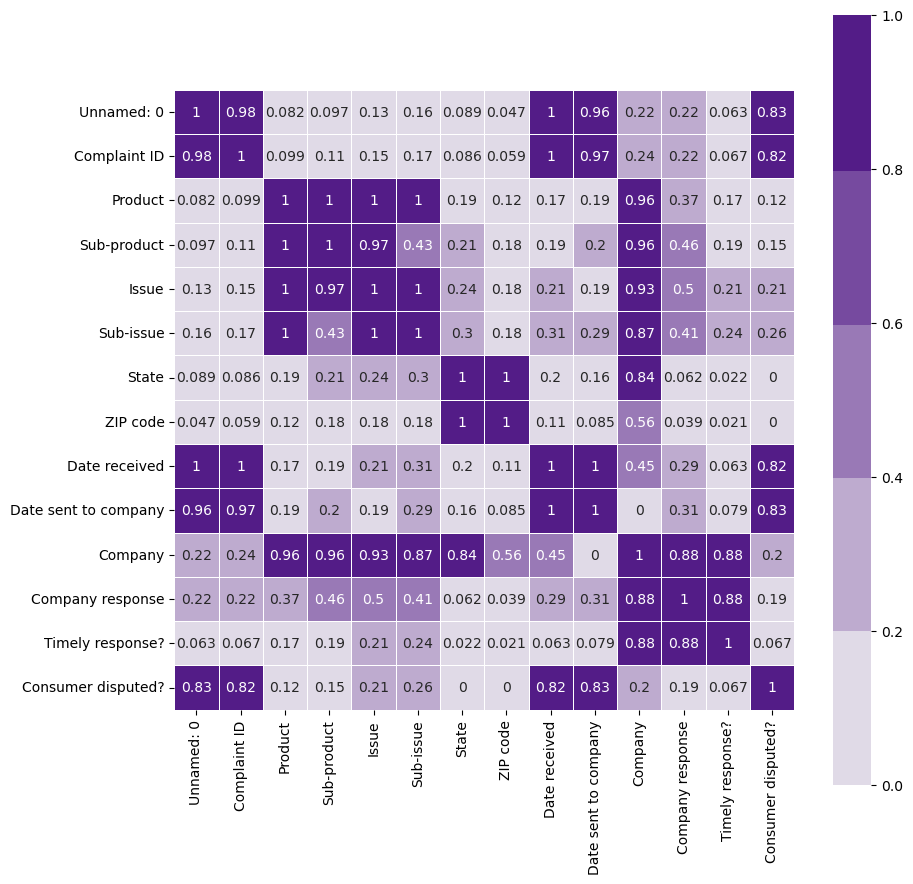

In [9]:
# Hemos cargado en Conda la librería phik por lo que no es necesario hacer !pip install phik
import phik

phik_matrix = datacopy.phik_matrix()

plt.figure(figsize=(10,10))
sns.heatmap(phik_matrix,
            vmin=0,
            vmax=1,
            center=0,
            cmap=sns.diverging_palette(145, 280, s=85, l=25, n=10),
            square=True,
            annot=True,
            linewidths=.5);

plt.savefig(path_img + 'Heatmap de Correlación coeficiente PhiK.tiff')

**Conclusiones sobre el heatmap:**
 1. Las variables "**Unnamed: 0**" y "**Complaint ID**" están altamente correladas entre ellas por lo que eliminaremos la primera. "`Complaint ID`" mantiene una correlación de 0.82 con "Date received" y "Date sent to company" y con la variable target "Consumer disputed?".
 2. Las variables "**State**" y "**ZIP code**" tienen una correlación nula con la variable target por lo que las eliminaremos ya que no influyen en ella y además tienen bastantes datos faltantes.
 3. Los pares de variables "`Product`"-"**Sub-product**" e "`Issue`"-"**Sub-issue**" tienen una correlación alta entre ellas por lo que eliminaremos una de cada pareja, también por tener más de un 30% de datos faltantes "Sub-product" y "Sub-issue".
 4. El `resto de variables` tienen una correlación alta entre ellas y baja de 0.12 a 0.21 con la variable target, pero las mantendremos para entrenar los modelos.


### **Imputación de valores faltantes**

Intentaremos imputar los valores faltantes pendientes de las features que quedan.

**"ZIP code" y "State"** 

In [10]:
# Creamos una función para corregir datos erroneos en "ZIP code"
def sustituir_zips_proximos(datacopy, df_zip):
    """
    Sustituye los 'ZIP code' de un datacopy por los más próximos de un df_zip.

    Args:
        datacopy (pd.DataFrame): DataFrame con la columna 'ZIP code' a corregir.
        df_zip (pd.DataFrame): DataFrame de referencia con una columna 'ZIP_ref'
                               que contiene los códigos ZIP correctos.

    Returns:
        pd.DataFrame: El DataFrame datacopy con los 'ZIP code' corregidos.
    """
    # 1. Crear una lista de ZIP codes de referencia
    zip_ref_list = df_zip['ZIP_ref'].dropna().unique().tolist()

    # 2. Convertir la lista de referencia a strings para get_close_matches
    zip_ref_str = [str(int(zip_code)) for zip_code in zip_ref_list]

    # 3. Iterar sobre las filas de datacopy para corregir
    for index, row in datacopy.iterrows():
        current_zip = row['ZIP code']

        # Omitir si el ZIP code actual es NaN
        if pd.isna(current_zip):
            continue

        str_current_zip = str(int(current_zip))

        # Verificar si el ZIP code está en la lista de referencia
        if str_current_zip in zip_ref_str:
            continue  # El ZIP es correcto, no se necesita corrección

        # Buscar la coincidencia más cercana
        # Hemos definido cutoff=0.5 para que la coincidencia sea al menos de un 50% de similitud. Asi obtenemos un valor para 'ZIP code' = 11
        from difflib import get_close_matches
        closest_matches = get_close_matches(str_current_zip, zip_ref_str, n=1, cutoff=0.5)

        if closest_matches:
            # Si se encuentra una coincidencia, sustituir el valor en el DataFrame
            corrected_zip = int(closest_matches[0])
            datacopy.at[index, 'ZIP code'] = corrected_zip

    return datacopy

In [11]:
# Aplicar la función para corregir los ZIP codes.
corregido_zip = sustituir_zips_proximos(datacopy, df_zip)
print(corregido_zip.isnull().sum())

Unnamed: 0                  0
Complaint ID                0
Product                     0
Sub-product             10574
Issue                       2
Sub-issue               14945
State                     421
ZIP code                  280
Date received               0
Date sent to company        0
Company                     0
Company response            0
Timely response?            0
Consumer disputed?      22150
dtype: int64


In [12]:
# DataFrame con "ZIP code" corregidos.
mapeo_ref = corregido_zip.copy()

dict_zip_mapeo = df_zip.set_index('State_ref')['ZIP_ref'].to_dict() # Diccionario de mapeo de referencia State to ZIP code.
mapeo_ref['ZIP code'] = mapeo_ref['ZIP code'].fillna(mapeo_ref['State'].map(dict_zip_mapeo)) # Rellenar datos NaN de mapeo_ref en la columna 'ZIP code'.

dict_state_mapeo = df_zip.set_index('ZIP_ref')['State_ref'].to_dict() # Diccionario de mapeo de referencia ZIP code to State.
mapeo_ref['State'] = mapeo_ref['State'].fillna(mapeo_ref['ZIP code'].map(dict_state_mapeo)) # Rellenar datos NaN de mapeo_ref en la columna 'State'.

#print (len(dict_zip_mapeo))
#print (len(dict_state_mapeo))

print(mapeo_ref.isnull().sum())
print ("_"*40)
mapeo_ref.info()

Unnamed: 0                  0
Complaint ID                0
Product                     0
Sub-product             10574
Issue                       2
Sub-issue               14945
State                     154
ZIP code                  154
Date received               0
Date sent to company        0
Company                     0
Company response            0
Timely response?            0
Consumer disputed?      22150
dtype: int64
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28156 entries, 0 to 28155
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            28156 non-null  int64  
 1   Complaint ID          28156 non-null  int64  
 2   Product               28156 non-null  object 
 3   Sub-product           17582 non-null  object 
 4   Issue                 28154 non-null  object 
 5   Sub-issue             13211 non-null  object 
 6   Stat

In [13]:
# DataFrame con "ZIP code" corregidos y con mapeo de datos faltantes con df_zip.
multimap = mapeo_ref.copy()

# 1. Crear un diccionario de mapeo para 'Company' y las otras columnas
columns_mapeo = ['Company', 'State', 'ZIP code']
multimap_ini = multimap[columns_mapeo].drop_duplicates().dropna()#.set_index('Company').to_dict(index=True)
error_ini = multimap_ini[multimap_ini['ZIP code'].isin(df_zip['ZIP_ref'])] 

# Convertir el DataFrame en un diccionario con el siguiente formato para la funcion de relleno.
# diccionario = {Company: {'State': row['State'], 'ZIP code': row['ZIP code']}}
dict_multimap = {
    row['Company']: {'State': row['State'], 'ZIP code': row['ZIP code']}
    for _, row in multimap_ini.iterrows()
}

# 2. Definimos una función de relleno para una fila
def rellenar_datos_completos(fila):
    id_actual = fila['Company']
    if id_actual in dict_multimap:     
        datos_mapeados = dict_multimap[id_actual]
                
        # Rellenar 'State' si es nulo
        if pd.isna(fila['State']):
            fila['State'] = datos_mapeados['State']
        
        # Rellenar 'ZIP code' si es nulo
        if pd.isna(fila['ZIP code']):
            fila['ZIP code'] = datos_mapeados['ZIP code']
            
    return fila

# 3. Aplicar la función al DataFrame
multimap_fin = multimap.apply(rellenar_datos_completos, axis=1)

print(multimap_fin.isnull().sum())
multimap_fin.info()

Unnamed: 0                  0
Complaint ID                0
Product                     0
Sub-product             10574
Issue                       2
Sub-issue               14945
State                       4
ZIP code                    4
Date received               0
Date sent to company        0
Company                     0
Company response            0
Timely response?            0
Consumer disputed?      22150
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28156 entries, 0 to 28155
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            28156 non-null  int64  
 1   Complaint ID          28156 non-null  int64  
 2   Product               28156 non-null  object 
 3   Sub-product           17582 non-null  object 
 4   Issue                 28154 non-null  object 
 5   Sub-issue             13211 non-null  object 
 6   State                 28152 non-null  object 

In [14]:
multimap_fin[multimap_fin["ZIP code"].isnull()]

,Unnamed: 0,Complaint ID,Product,Sub-product,Issue,Sub-issue,State,ZIP code,Date received,Date sent to company,Company,Company response,Timely response?,Consumer disputed?
3946,3946,1258602,Mortgage,Other mortgage,Credit decision / Underwriting,NaN,NaN,NaN,2015-02-26,2015-03-04,"George Mason Mortgage, LLC",Closed with explanation,Yes,NaN
13738,13738,1226330,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,2015-02-04,2015-02-12,The PrivateBank and Trust Company,Closed with explanation,Yes,NaN
13941,13941,1225685,Consumer loan,Vehicle loan,Shopping for a loan or lease,NaN,NaN,NaN,2015-02-04,2015-02-11,"BlueYield, Inc.",Closed,Yes,NaN
25639,25639,1186407,Debt collection,Credit card,Disclosure verification of debt,Not given enough info to verify debt,NaN,NaN,2015-01-08,2015-01-13,"Global Asset Management Group, Inc.",Closed with explanation,Yes,NaN


In [15]:
# Buscamos en google los datos de las empresas faltantes y los incorporamos en un diccionario.
dict_faltantes = {'George Mason Mortgage, LLC': {'State': 'VA', 'ZIP code': 22030},
                  'The PrivateBank and Trust Company': {'State': 'IL', 'ZIP code': 60603},
                  'BlueYield, Inc.': {'State': 'CA', 'ZIP code': 92656},
                  'Global Asset Management Group, Inc.': {'State': 'FL', 'ZIP code': 32779} }

# dict_multimap_new = {**dict_multimap, **dict_faltantes} # Actualizamos el diccionario.
dict_faltantes

{'George Mason Mortgage, LLC': {'State': 'VA', 'ZIP code': 22030},
 'The PrivateBank and Trust Company': {'State': 'IL', 'ZIP code': 60603},
 'BlueYield, Inc.': {'State': 'CA', 'ZIP code': 92656},
 'Global Asset Management Group, Inc.': {'State': 'FL', 'ZIP code': 32779}}

In [16]:
# Actualizamos el diccionario con los datos faltantes
dict_multimap.update(dict_faltantes)
print (len(dict_multimap))

1534


In [17]:
# Volvemos a aplicar la función de relleno al DataFrame
multimap_fin = multimap.apply(rellenar_datos_completos, axis=1)
multimap_fin["ZIP code"] = multimap_fin["ZIP code"].to_numpy(dtype=int)

print(multimap_fin.isnull().sum())
multimap_fin.info()

Unnamed: 0                  0
Complaint ID                0
Product                     0
Sub-product             10574
Issue                       2
Sub-issue               14945
State                       0
ZIP code                    0
Date received               0
Date sent to company        0
Company                     0
Company response            0
Timely response?            0
Consumer disputed?      22150
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28156 entries, 0 to 28155
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Unnamed: 0            28156 non-null  int64 
 1   Complaint ID          28156 non-null  int64 
 2   Product               28156 non-null  object
 3   Sub-product           17582 non-null  object
 4   Issue                 28154 non-null  object
 5   Sub-issue             13211 non-null  object
 6   State                 28156 non-null  object
 7   ZIP

In [18]:
# Creamos las columnas sin NaN en datacopy
datacopy["State_NN"] = multimap_fin ["State"]
datacopy["ZIP_NN"] = multimap_fin ["ZIP code"]

**"Issue"** 

In [19]:
# Mostramos datos faltantes de Issue
filterProduct = datacopy['Product'].notna() & datacopy['Issue'].isna() 
datacopy[['Product',  'Issue']][filterProduct]

,Product,Issue
11730,Bank account or service,NaN
13198,Bank account or service,NaN


In [20]:
maskProduct = (datacopy['Product'] == 'Bank account or service')
datacopy[['Product', 'Issue']][maskProduct].value_counts()

Product                  Issue                                   
Bank account or service  Account opening, closing, or management     1142
                         Deposits and withdrawals                     690
                         Problems caused by my funds being low        337
                         Making/receiving payments, sending money     233
                         Using a debit or ATM card                    205
Name: count, dtype: int64

In [21]:
datacopy['Issue_NN']= datacopy['Issue'].fillna('Account opening, closing, or management')

In [22]:
datacopy['Issue_NN'].isna().sum()

np.int64(0)

**"Consumer disputed?" (Target)** 

In [23]:
# Tratamiento de valores faltantes (NaN)
# La variable 'Consumer disputed?' se imputa con 'Unknown' para poder operar.
datacopy['Consumer_disputed_NN'] = datacopy['Consumer disputed?'].fillna('Unknown')

### **Feature Engineering**

**Nueva característica: "Day received"**

In [24]:
# Transformación a nueva caracteristica 'Day received' como valor numérico: 'Día del año recibido'. 
datacopy['Date received'] = pd.to_datetime(datacopy['Date received'])

datacopy['Day_received'] = datacopy['Date received'].dt.dayofyear
print (datacopy['Day_received'].sort_values(ascending=True).unique())


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78]


**Nueva característica: "Response time"**

In [25]:
# Creación de una nueva característica: 'Tiempo de respuesta'
datacopy['Date sent to company'] = pd.to_datetime(datacopy['Date sent to company'])
datacopy['Response_time'] = (datacopy['Date sent to company'] - datacopy['Date received']).dt.days

print("Se ha creado la característica 'Response time'.")
print (datacopy['Response_time'].sort_values(ascending=True).unique())

Se ha creado la característica 'Response time'.
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 52 53 55 57 59 60 61 64]


**Transformación numérica (Encoding): "Product"**

In [26]:
datacopy['Product'].value_counts()

Product
Debt collection            7494
Mortgage                   6612
Credit reporting           5717
Credit card                2830
Bank account or service    2609
Consumer loan              1314
Student loan                785
Payday loan                 348
Money transfers             232
Prepaid card                175
Other financial service      40
Name: count, dtype: int64

In [27]:
datacopy['Product'].value_counts()

# Listamos en un diccionario los productos con su código numérico.
dict_product = {
    'Debt collection': 1, 'Mortgage': 2, 'Credit reporting': 3, 'Credit card': 4, 'Bank account or service': 5, 'Consumer loan': 6,
    'Student loan': 7, 'Payday loan': 8, 'Money transfers': 9, 'Prepaid card': 10, 'Other financial service': 11
}

# Aplicamos un mapeado
datacopy['Product_num'] = datacopy['Product'].map(dict_product)

**Transformación numérica (Encoding): "State"**

In [28]:
# Listamos en un diccionario los estados con su código numérico.
dict_state = {
    'AE':1, 'AK':2, 'AL':3, 'AP':4, 'AR':5, 'AS':6, 'AZ':7, 'CA':8, 'CO':9, 'CT':10, 'DC':11,
    'DE':12, 'FL':13, 'GA':14, 'GU':15, 'HI':16, 'IA':17, 'ID':18, 'IL':19, 'IN':20, 'KS':21,
    'KY':22, 'LA':23, 'MA':24, 'MD':25, 'ME':26, 'MH':27, 'MI':28, 'MN':29, 'MO':30, 'MS':31,
    'MT':32, 'NC':33, 'ND':34, 'NE':35, 'NH':36, 'NJ':37, 'NM':38, 'NV':39, 'NY':40, 'OH':41,
    'OK':42, 'OR':43, 'PA':44, 'PR':45, 'PW':46, 'RI':47, 'SC':48, 'SD':49, 'TN':50, 'TX':51,
    'UT':52, 'VA':53, 'VI':54, 'VT':55, 'WA':56, 'WI':57, 'WV':58, 'WY':59
    }
# Aplicamos un mapeado
datacopy['State_num'] = datacopy['State_NN'].map(dict_state)

**Transformación binaria (Encoding): "Timely response?"**

In [29]:
# Preparación de la variable "Timely response?"
datacopy['Timely_response_bin'] = datacopy['Timely response?'].map({'Yes': 1, 'No': 0})

**Transformación numérica (Encoding): "Company response"**

In [30]:
# Creamos un diccionario con las caracteristicas numéricas
respuesta = {
    "Closed with explanation" : 1,
    "Closed with non-monetary relief" : 2,
    "In progress" : 3,
    "Closed with monetary relief" : 4,
    "Closed" : 5,
    "Untimely response" : 6
    }
# Creación de una característica binaria para la respuesta
datacopy['Company_response_num'] = datacopy['Company response'].map(respuesta)

**Transformación numérica (Encoding): "Consumer disputed?"**

In [31]:
# Preparación de la variable objetivo
Cons_No= datacopy['Consumer_disputed_NN'].str.contains('No')
Cons_Yes= datacopy['Consumer_disputed_NN'].str.contains('Yes')
Cons_Unknown = datacopy['Consumer_disputed_NN'].str.contains('Unknown')

options = [0,1,2]

datacopy['Consumer_disputed_num'] = np.select([Cons_No, Cons_Yes, Cons_Unknown], options)
datacopy['Consumer_disputed_num'].head()

0    2
1    2
2    1
3    2
4    2
Name: Consumer_disputed_num, dtype: int64

**Filtrado y Transformación numérica (Encoding): "Issue"**

In [32]:
Issue_frec = datacopy['Issue_NN'].value_counts() 
best_issues = Issue_frec[Issue_frec > 100].index
datacopy["Issue_filter"] = datacopy["Issue_NN"].where(datacopy["Issue_NN"].isin(best_issues))
encoder = LabelEncoder()

In [33]:
cond1_Issue_brand = datacopy['Issue_filter'].str.contains('credit', na=False)
cond2_Issue_brand = datacopy['Issue_filter'].str.contains('loan', na=False)
cond3_Issue_brand = datacopy['Issue_filter'].str.contains('debt', na=False)
cond4_Issue_brand = datacopy['Issue_filter'].str.contains('mortage', na=False)
cond5_Issue_brand = datacopy['Issue_filter'].str.contains('card', na=False)
cond6_Issue_brand = datacopy['Issue_filter'].str.contains('service', na=False)

conditions_Issue_brand = [cond1_Issue_brand, cond2_Issue_brand, cond3_Issue_brand, cond4_Issue_brand, cond5_Issue_brand, cond6_Issue_brand]

options = ['Credit', 'Loan', 'Debt', 'Mortage', 'Card', 'Service']  # Define the options for each condition

datacopy['Issue_brand'] = np.select(conditions_Issue_brand, options, default='Others') # El resto de las condiciones se agrupan en 'Others'
datacopy.head()

,Unnamed: 0,Complaint ID,Product,Sub-product,Issue,Sub-issue,State,ZIP code,Date received,Date sent to company,...,Consumer_disputed_NN,Day_received,Response_time,Product_num,State_num,Timely_response_bin,Company_response_num,Consumer_disputed_num,Issue_filter,Issue_brand
0,0,1291006,Debt collection,NaN,Communication tactics,Frequent or repeated calls,TX,76119.0,2015-03-19,2015-03-19,...,Unknown,78,0,1,51,1,3,2,Communication tactics,Others
1,1,1290580,Debt collection,Medical,Cont'd attempts collect debt not owed,Debt is not mine,TX,77479.0,2015-03-19,2015-03-19,...,Unknown,78,0,1,51,1,1,2,Cont'd attempts collect debt not owed,Debt
2,2,1290564,Mortgage,FHA mortgage,"Application, originator, mortgage broker",NaN,MA,2127.0,2015-03-19,2015-03-19,...,Yes,78,0,2,24,1,1,1,"Application, originator, mortgage broker",Others
3,3,1291615,Credit card,NaN,Other,NaN,CA,92592.0,2015-03-19,2015-03-19,...,Unknown,78,0,4,8,1,3,2,Other,Others
4,4,1292165,Debt collection,Non-federal student loan,Cont'd attempts collect debt not owed,Debt resulted from identity theft,NaN,43068.0,2015-03-19,2015-03-19,...,Unknown,78,0,1,41,1,3,2,Cont'd attempts collect debt not owed,Debt


In [34]:
datacopy['Issue_num'] = encoder.fit_transform(datacopy['Issue_brand'])

**Filtrado y Transformación numérica (Encoding): "Company"**

In [35]:
Company_frec = datacopy['Company'].value_counts() 
best_companies = Company_frec[Company_frec > 100].index
datacopy["Company_filter"] = datacopy["Company"].where(datacopy["Company"].isin(best_issues))
encoder = LabelEncoder()

In [36]:
# Filter datacopy to only include rows where Company is in FrequentCompanies
datacopy['Company_filter'] = np.where(
    datacopy['Company'].isin(Company_frec.index),
    datacopy['Company'],
    'Other'
)

In [37]:
frequency_encoding = datacopy['Company_filter'].value_counts()

# Map those frequencies back to the original column
datacopy['Company_num'] = datacopy['Company_filter'].map(frequency_encoding).fillna(0).astype(int)

In [38]:
datacopy.head()

,Unnamed: 0,Complaint ID,Product,Sub-product,Issue,Sub-issue,State,ZIP code,Date received,Date sent to company,...,Product_num,State_num,Timely_response_bin,Company_response_num,Consumer_disputed_num,Issue_filter,Issue_brand,Issue_num,Company_filter,Company_num
0,0,1291006,Debt collection,NaN,Communication tactics,Frequent or repeated calls,TX,76119.0,2015-03-19,2015-03-19,...,1,51,1,3,2,Communication tactics,Others,4,"Premium Asset Services, LLC",41
1,1,1290580,Debt collection,Medical,Cont'd attempts collect debt not owed,Debt is not mine,TX,77479.0,2015-03-19,2015-03-19,...,1,51,1,1,2,Cont'd attempts collect debt not owed,Debt,2,Accounts Receivable Consultants Inc.,1
2,2,1290564,Mortgage,FHA mortgage,"Application, originator, mortgage broker",NaN,MA,2127.0,2015-03-19,2015-03-19,...,2,24,1,1,1,"Application, originator, mortgage broker",Others,4,RBS Citizens,107
3,3,1291615,Credit card,NaN,Other,NaN,CA,92592.0,2015-03-19,2015-03-19,...,4,8,1,3,2,Other,Others,4,Navy FCU,62
4,4,1292165,Debt collection,Non-federal student loan,Cont'd attempts collect debt not owed,Debt resulted from identity theft,NaN,43068.0,2015-03-19,2015-03-19,...,1,41,1,3,2,Cont'd attempts collect debt not owed,Debt,2,Transworld Systems Inc.,215


### **Análisis Exploratorio de Datos (EDA)**

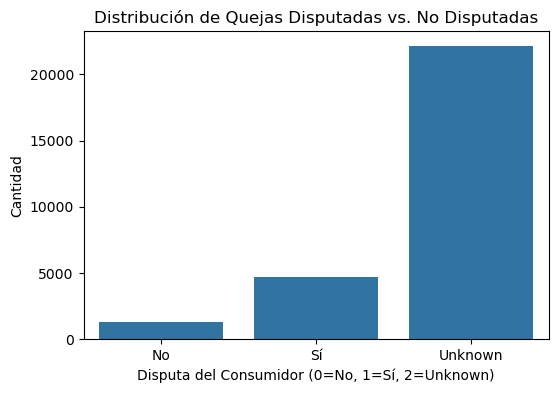

El gráfico muestra un desequilibrio de clases, lo que deberá ser considerado en el modelado.


<Figure size 640x480 with 0 Axes>

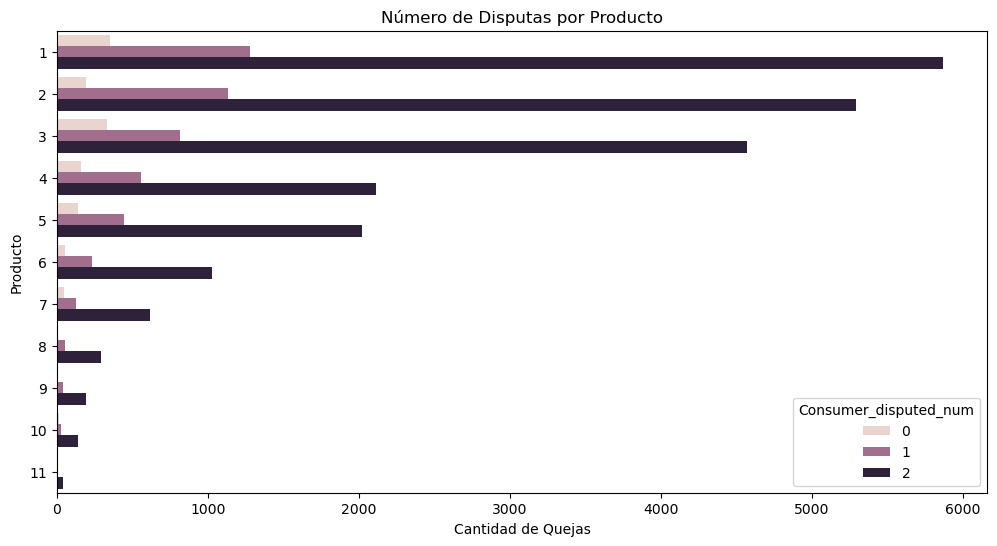

<Figure size 640x480 with 0 Axes>

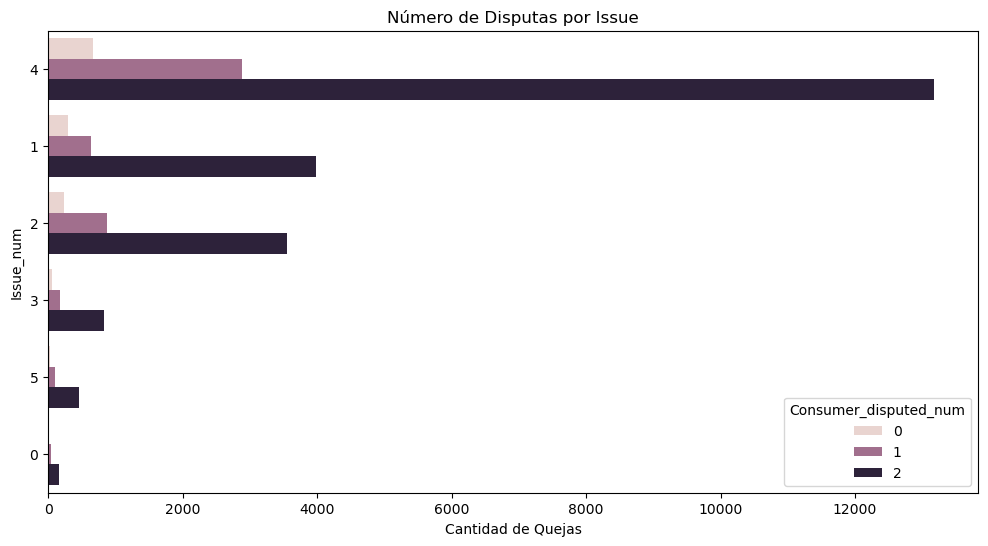

<Figure size 640x480 with 0 Axes>

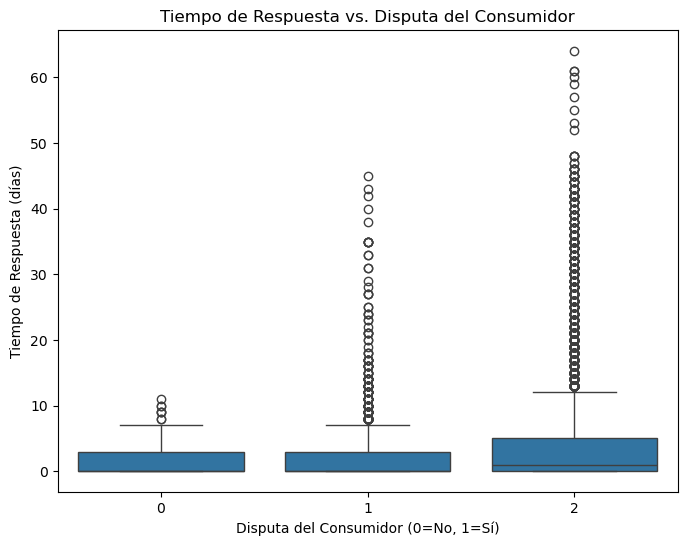

<Figure size 640x480 with 0 Axes>

In [39]:
# a. Distribución de la variable objetivo
plt.figure(figsize=(6, 4))
sns.countplot(x='Consumer_disputed_num', data=datacopy)
plt.title('Distribución de Quejas Disputadas vs. No Disputadas')
plt.xlabel('Disputa del Consumidor (0=No, 1=Sí, 2=Unknown)')
plt.ylabel('Cantidad')
plt.xticks(ticks=[0, 1, 2], labels=['No', 'Sí', 'Unknown'])
plt.show()
plt.savefig(path_img + 'Distribución de la variable objetivo.tiff')
print("El gráfico muestra un desequilibrio de clases, lo que deberá ser considerado en el modelado.")

# b. Relación entre "Product" y la variable objetivo
plt.figure(figsize=(12, 6))
sns.countplot(y='Product_num', hue='Consumer_disputed_num', data=datacopy, order=datacopy['Product_num'].value_counts().index)
plt.title('Número de Disputas por Producto')
plt.xlabel('Cantidad de Quejas')
plt.ylabel('Producto')
plt.show()
plt.savefig(path_img + 'Relación entre -Product- y la variable objetivo.tiff')

# c. Relación entre "Issue" y la variable objetivo
plt.figure(figsize=(12, 6))
sns.countplot(y='Issue_num', hue='Consumer_disputed_num', data=datacopy, order=datacopy['Issue_num'].value_counts().head(15).index)
plt.title('Número de Disputas por Issue')
plt.xlabel('Cantidad de Quejas')
plt.ylabel('Issue_num')
plt.show()
plt.savefig(path_img + 'Relación entre -Issue- y la variable objetivo.tiff')

# d. Relación de "Response time" y la variable objetivo
plt.figure(figsize=(8, 6))
sns.boxplot(x='Consumer_disputed_num', y='Response_time', data=datacopy)
plt.title('Tiempo de Respuesta vs. Disputa del Consumidor')
plt.xlabel('Disputa del Consumidor (0=No, 1=Sí)')
plt.ylabel('Tiempo de Respuesta (días)')
plt.show()
plt.savefig(path_img + 'Relación de -Response time- y la variable objetivo.tiff')

### **Preparación de los datos para el Entrenamiento de Modelos**

In [40]:
datacopy.columns

Index(['Unnamed: 0', 'Complaint ID', 'Product', 'Sub-product', 'Issue',
       'Sub-issue', 'State', 'ZIP code', 'Date received',
       'Date sent to company', 'Company', 'Company response',
       'Timely response?', 'Consumer disputed?', 'State_NN', 'ZIP_NN',
       'Issue_NN', 'Consumer_disputed_NN', 'Day_received', 'Response_time',
       'Product_num', 'State_num', 'Timely_response_bin',
       'Company_response_num', 'Consumer_disputed_num', 'Issue_filter',
       'Issue_brand', 'Issue_num', 'Company_filter', 'Company_num'],
      dtype='object')

**Eliminación final de Features**

Una vez hecho el análisis de nuestras variables y tenido en cuenta el módelo de negocio propuesto (predecir si el cliente disputara o no, la respuesta del cliente) llega el momento de limpiar el dataset. Eliminaremos las siguientes features:

In [41]:
# Podríamos eliminar las columnas "State" y "ZIP code" por no tener correlación lineal con el target, pero las tendremos en cuenta ya que hemos imputado los datos faltantes.
# Según las conclusiones obtenidas del heatmap de Phik, eliminamos las columnas repetidas y que no aportan nada.

In [42]:
df_processed = datacopy.drop(columns=['Unnamed: 0', 'Product', 'Sub-product', 'Issue',
       'Sub-issue', 'State', 'ZIP code','ZIP_NN', 'Date received', 'Date sent to company', 'Company', 'Company response',
       'Timely response?', 'Consumer disputed?', 'State_NN', 'Issue_NN', 'Issue_filter',
       'Issue_brand', 'Company_filter', 'Consumer_disputed_NN'])

**Ordenamos el DataFrame**

In [43]:
# Ordenamos el dataframe según la columna "Complaint ID".
df_processed = df_processed.sort_values(by = "Complaint ID", ascending=True)


In [44]:
df_processed.set_index("Complaint ID").sort_index()
df_processed = df_processed.reset_index(drop=True)

In [45]:
df_processed.info()
df_processed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28156 entries, 0 to 28155
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   Complaint ID           28156 non-null  int64
 1   Day_received           28156 non-null  int32
 2   Response_time          28156 non-null  int64
 3   Product_num            28156 non-null  int64
 4   State_num              28156 non-null  int64
 5   Timely_response_bin    28156 non-null  int64
 6   Company_response_num   28156 non-null  int64
 7   Consumer_disputed_num  28156 non-null  int64
 8   Issue_num              28156 non-null  int64
 9   Company_num            28156 non-null  int64
dtypes: int32(1), int64(9)
memory usage: 2.0 MB


,Complaint ID,Day_received,Response_time,Product_num,State_num,Timely_response_bin,Company_response_num,Consumer_disputed_num,Issue_num,Company_num
0,1177839,1,0,3,7,1,2,0,1,1940
1,1177844,1,0,9,44,1,1,1,4,112
2,1177846,1,0,3,40,1,2,0,4,1525
3,1177928,1,0,6,5,1,1,0,3,133
4,1177930,1,0,2,8,1,1,1,4,1430
...,...,...,...,...,...,...,...,...,...,...
28151,1290580,78,0,1,51,1,1,2,2,1
28152,1291006,78,0,1,51,1,3,2,4,41
28153,1291176,78,0,1,41,1,3,2,4,53
28154,1291615,78,0,4,8,1,3,2,4,62


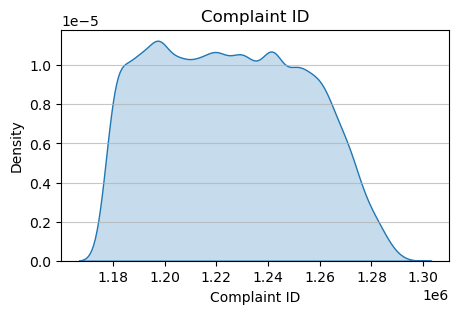

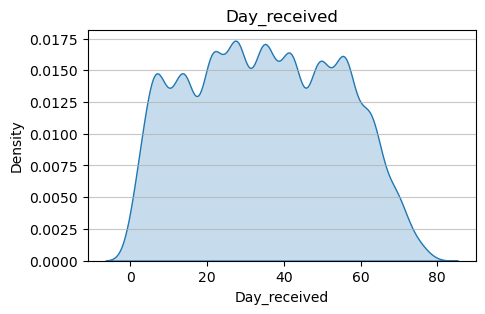

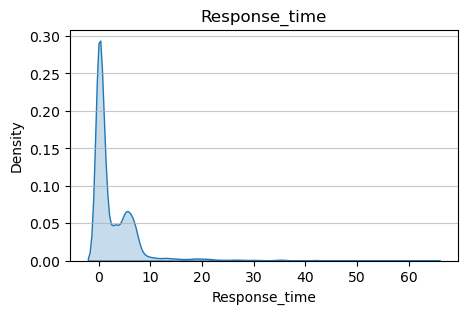

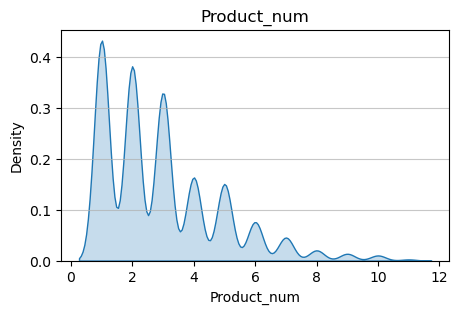

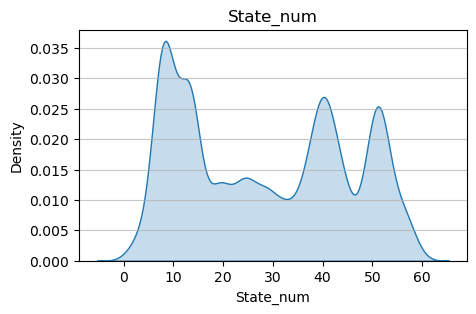

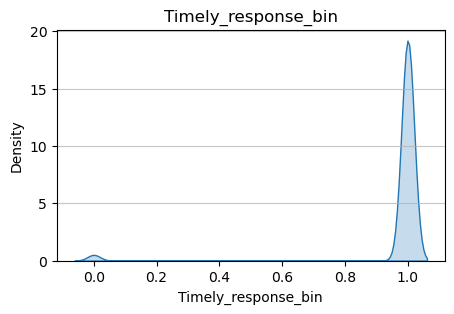

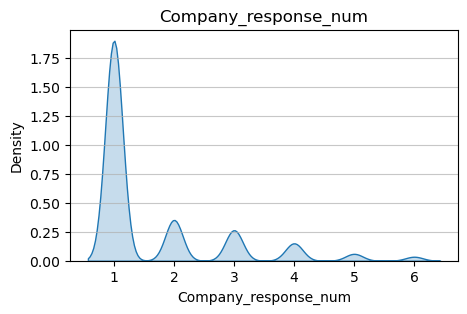

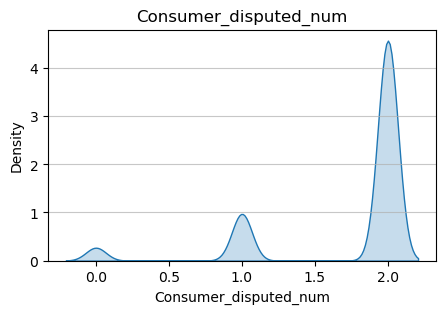

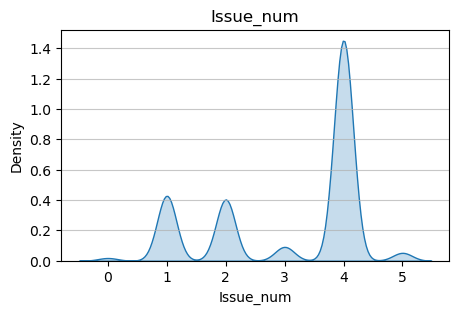

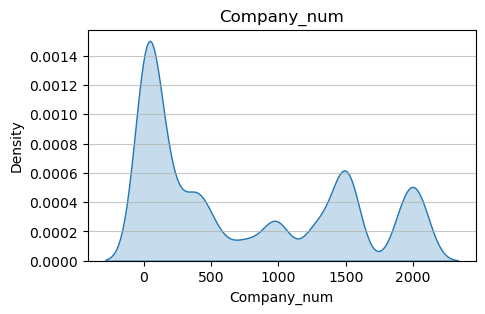

In [46]:
#Study of variable distributions
for columns in df_processed.columns: 
    plt.figure(figsize=(5,3))
    sns.kdeplot(df_processed[columns], fill=True);
    plt.title(columns)
    plt.xlabel(columns)
    plt.ylabel('Density')
    plt.grid(axis='y', alpha=0.7)
    plt.show();

In [47]:
# Guardar el DataFrame preprocesado para el siguiente notebook
df_processed.to_csv(path_data + 'df_processed.csv')
print("\nDataFrame procesado guardado como 'df_processed.csv' para el entrenamiento.")


DataFrame procesado guardado como 'df_processed.csv' para el entrenamiento.


### **Se realizo un Clustering inicialmente para obtener conclusiones, pero se descarto**

In [106]:
# 1. Cargamos el DataFrame con datos mixtos y faltantes.
df_relleno = pd.read_csv (path_data + "df_relleno.csv", sep=",", encoding="utf-8")
df_relleno.head()

,Complaint ID,Product,Sub-product,Issue,Sub-issue,State,ZIP code,Company,Company response,Timely response?,Consumer disputed?,Delay Time
0,1291006,Debt collection,Sin datos,Communication tactics,Frequent or repeated calls,TX,76119,"Premium Asset Services, LLC",In progress,Yes,Sin datos,0
1,1290580,Debt collection,Medical,Cont'd attempts collect debt not owed,Debt is not mine,TX,77479,Accounts Receivable Consultants Inc.,Closed with explanation,Yes,Sin datos,0
2,1290564,Mortgage,FHA mortgage,"Application, originator, mortgage broker",Sin datos,MA,2127,RBS Citizens,Closed with explanation,Yes,Yes,0
3,1291615,Credit card,Sin datos,Other,Sin datos,CA,92592,Navy FCU,In progress,Yes,Sin datos,0
4,1292165,Debt collection,Non-federal student loan,Cont'd attempts collect debt not owed,Debt resulted from identity theft,OH,43068,Transworld Systems Inc.,In progress,Yes,Sin datos,0


In [107]:
df_relleno.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28156 entries, 0 to 28155
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Complaint ID        28156 non-null  int64 
 1   Product             28156 non-null  object
 2   Sub-product         28156 non-null  object
 3   Issue               28156 non-null  object
 4   Sub-issue           28156 non-null  object
 5   State               28156 non-null  object
 6   ZIP code            28156 non-null  int64 
 7   Company             28156 non-null  object
 8   Company response    28156 non-null  object
 9   Timely response?    28156 non-null  object
 10  Consumer disputed?  28156 non-null  object
 11  Delay Time          28156 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 2.6+ MB


In [108]:
print(df_relleno.isnull().sum())

Complaint ID          0
Product               0
Sub-product           0
Issue                 0
Sub-issue             0
State                 0
ZIP code              0
Company               0
Company response      0
Timely response?      0
Consumer disputed?    0
Delay Time            0
dtype: int64


In [109]:
# Crear una copia para la imputación
df_imputed = df_relleno.copy()

In [110]:
# Para que el algoritmo de clustering funcione se deben imputar temporalmente los NaN.
"""
for col in numerical_cols:
    df_imputed[col] = df_imputed[col].fillna(df_imputed[col].median())
for col in categorical_cols:
    df_imputed[col] = df_imputed[col].fillna(df_imputed[col].mode()[0])
"""

'\nfor col in numerical_cols:\n    df_imputed[col] = df_imputed[col].fillna(df_imputed[col].median())\nfor col in categorical_cols:\n    df_imputed[col] = df_imputed[col].fillna(df_imputed[col].mode()[0])\n'

In [111]:
df_imputed.head()

,Complaint ID,Product,Sub-product,Issue,Sub-issue,State,ZIP code,Company,Company response,Timely response?,Consumer disputed?,Delay Time
0,1291006,Debt collection,Sin datos,Communication tactics,Frequent or repeated calls,TX,76119,"Premium Asset Services, LLC",In progress,Yes,Sin datos,0
1,1290580,Debt collection,Medical,Cont'd attempts collect debt not owed,Debt is not mine,TX,77479,Accounts Receivable Consultants Inc.,Closed with explanation,Yes,Sin datos,0
2,1290564,Mortgage,FHA mortgage,"Application, originator, mortgage broker",Sin datos,MA,2127,RBS Citizens,Closed with explanation,Yes,Yes,0
3,1291615,Credit card,Sin datos,Other,Sin datos,CA,92592,Navy FCU,In progress,Yes,Sin datos,0
4,1292165,Debt collection,Non-federal student loan,Cont'd attempts collect debt not owed,Debt resulted from identity theft,OH,43068,Transworld Systems Inc.,In progress,Yes,Sin datos,0


In [112]:
# Identificar columnas numéricas y categóricas
numerical_cols = df_imputed.select_dtypes(include=[np.number])
categorical_cols = df_imputed.select_dtypes(exclude=[np.number])

In [113]:
numerical_cols

,Complaint ID,ZIP code,Delay Time
0,1291006,76119,0
1,1290580,77479,0
2,1290564,2127,0
3,1291615,92592,0
4,1292165,43068,0
...,...,...,...
28151,1178184,75201,1
28152,1178183,30043,6
28153,1178182,55105,1
28154,1178181,92509,6


In [114]:
from sklearn.preprocessing import StandardScaler
# 3. Escalar las variables numéricas para el clustering
scaler = StandardScaler()
scaler.fit_transform(numerical_cols)

array([[ 2.31865285,  0.85242692, -0.54363569],
       [ 2.30362757,  0.89670301, -0.54363569],
       [ 2.30306324, -1.55645322, -0.54363569],
       ...,
       [-1.66071909,  0.1682961 , -0.35994466],
       [-1.66075436,  1.386019  ,  0.55851052],
       [-1.66078963, -0.15846801, -0.35994466]], shape=(28156, 3))

In [115]:
from kmodes.kprototypes import KPrototypes
# 4. Encontrar el K óptimo con el Método del Codo para K-Prototypes
costo_inercia = []
num_clusters = range(1, 11)
cat_indices = [df_imputed.columns.get_loc(col) for col in categorical_cols]

for k in num_clusters:
    try:
        kproto = KPrototypes(n_clusters=k, init='Cao', n_init=5, random_state=42, n_jobs=-1)
        kproto.fit_predict(df_imputed.values, categorical=cat_indices)
        costo_inercia.append(kproto.cost_)
    except Exception as e:
        print(f"Error para K={k}: {e}")

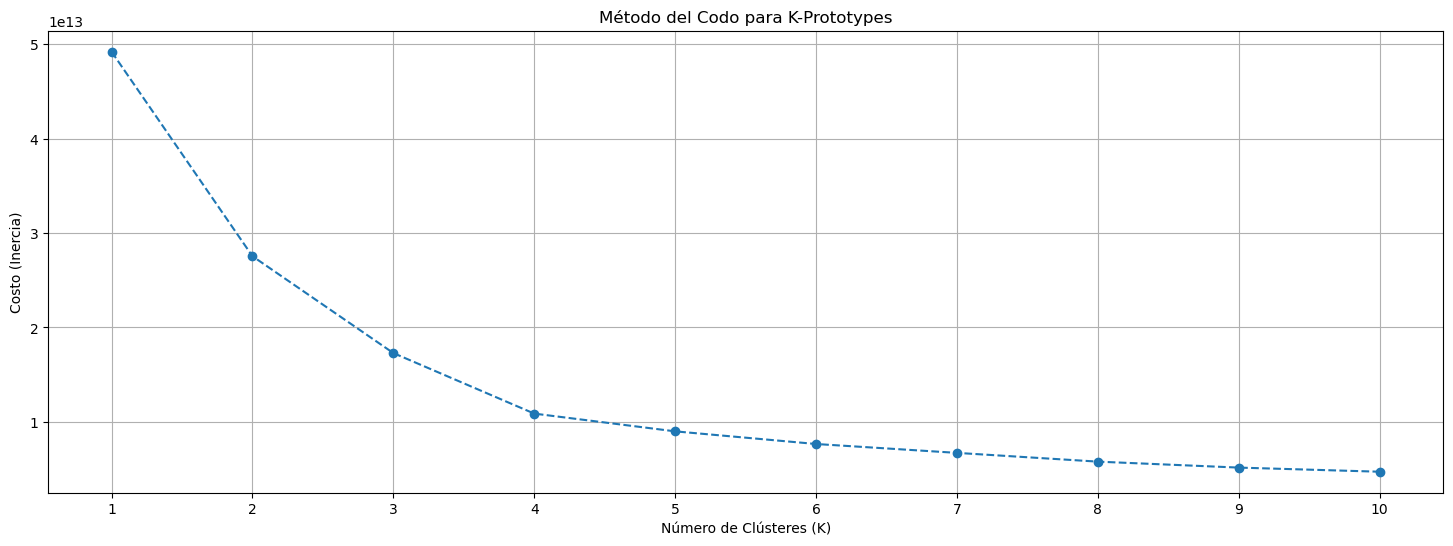

In [125]:
# Gráfico del Método del Codo
plt.figure(figsize=(18, 6))
plt.plot(num_clusters, costo_inercia, marker='o', linestyle='--')
plt.title('Método del Codo para K-Prototypes')
plt.xlabel('Número de Clústeres (K)')
plt.ylabel('Costo (Inercia)')
plt.xticks(num_clusters)
plt.grid(True)
plt.show()

In [117]:
# Se elige el K óptimo entre 4 y 8 (suponemos que el codo está en K=6)
optimal_k = 6

In [118]:
# 5. Aplicar Clustering K-Prototypes con el K óptimo
kproto = KPrototypes(n_clusters=optimal_k, init='Cao', n_init=5, random_state=42, n_jobs=-1)
clusters = kproto.fit_predict(df_imputed.values, categorical=cat_indices)
df_imputed['cluster'] = clusters

print(f"\nDataFrame con {optimal_k} clústeres:")
df_imputed


DataFrame con 6 clústeres:


,Complaint ID,Product,Sub-product,Issue,Sub-issue,State,ZIP code,Company,Company response,Timely response?,Consumer disputed?,Delay Time,cluster
0,1291006,Debt collection,Sin datos,Communication tactics,Frequent or repeated calls,TX,76119,"Premium Asset Services, LLC",In progress,Yes,Sin datos,0,3
1,1290580,Debt collection,Medical,Cont'd attempts collect debt not owed,Debt is not mine,TX,77479,Accounts Receivable Consultants Inc.,Closed with explanation,Yes,Sin datos,0,3
2,1290564,Mortgage,FHA mortgage,"Application, originator, mortgage broker",Sin datos,MA,2127,RBS Citizens,Closed with explanation,Yes,Yes,0,0
3,1291615,Credit card,Sin datos,Other,Sin datos,CA,92592,Navy FCU,In progress,Yes,Sin datos,0,3
4,1292165,Debt collection,Non-federal student loan,Cont'd attempts collect debt not owed,Debt resulted from identity theft,OH,43068,Transworld Systems Inc.,In progress,Yes,Sin datos,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28151,1178184,Debt collection,Sin datos,Cont'd attempts collect debt not owed,Debt is not mine,TX,75201,"Enhanced Recovery Company, LLC",Closed with non-monetary relief,Yes,No,1,2
28152,1178183,Consumer loan,Vehicle loan,Taking out the loan or lease,Sin datos,GA,30043,DriveTime,Closed with explanation,Yes,Sin datos,6,5
28153,1178182,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",Sin datos,MN,55105,Regions,Closed with non-monetary relief,Yes,No,1,2
28154,1178181,Payday loan,Sin datos,Can't stop charges to bank account,Sin datos,CA,92509,Moneytree Inc,Closed with explanation,Yes,Sin datos,6,2


In [119]:
# 6. Imputación final por clúster
# Ahora imputamos los valores del DataFrame original (df)
df_final = df_imputed.copy()

for col in numerical_cols:
    df_final[col] = df_final.groupby(clusters)[col].transform(lambda x: x.fillna(x.median()))

for col in categorical_cols:
    df_final[col] = df_final.groupby(clusters)[col].transform(lambda x: x.fillna(x.mode()[0]))

print("\nVerificación de nulos en el DataFrame final:")
print(df_final.isnull().sum())

print("\nDataFrame Final sin datos faltantes (imputación por clúster):")
df_final


Verificación de nulos en el DataFrame final:
Complaint ID          0
Product               0
Sub-product           0
Issue                 0
Sub-issue             0
State                 0
ZIP code              0
Company               0
Company response      0
Timely response?      0
Consumer disputed?    0
Delay Time            0
cluster               0
dtype: int64

DataFrame Final sin datos faltantes (imputación por clúster):


,Complaint ID,Product,Sub-product,Issue,Sub-issue,State,ZIP code,Company,Company response,Timely response?,Consumer disputed?,Delay Time,cluster
0,1291006,Debt collection,Sin datos,Communication tactics,Frequent or repeated calls,TX,76119,"Premium Asset Services, LLC",In progress,Yes,Sin datos,0,3
1,1290580,Debt collection,Medical,Cont'd attempts collect debt not owed,Debt is not mine,TX,77479,Accounts Receivable Consultants Inc.,Closed with explanation,Yes,Sin datos,0,3
2,1290564,Mortgage,FHA mortgage,"Application, originator, mortgage broker",Sin datos,MA,2127,RBS Citizens,Closed with explanation,Yes,Yes,0,0
3,1291615,Credit card,Sin datos,Other,Sin datos,CA,92592,Navy FCU,In progress,Yes,Sin datos,0,3
4,1292165,Debt collection,Non-federal student loan,Cont'd attempts collect debt not owed,Debt resulted from identity theft,OH,43068,Transworld Systems Inc.,In progress,Yes,Sin datos,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28151,1178184,Debt collection,Sin datos,Cont'd attempts collect debt not owed,Debt is not mine,TX,75201,"Enhanced Recovery Company, LLC",Closed with non-monetary relief,Yes,No,1,2
28152,1178183,Consumer loan,Vehicle loan,Taking out the loan or lease,Sin datos,GA,30043,DriveTime,Closed with explanation,Yes,Sin datos,6,5
28153,1178182,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",Sin datos,MN,55105,Regions,Closed with non-monetary relief,Yes,No,1,2
28154,1178181,Payday loan,Sin datos,Can't stop charges to bank account,Sin datos,CA,92509,Moneytree Inc,Closed with explanation,Yes,Sin datos,6,2


In [120]:
df_final_cluster = df_final.groupby("cluster")
df_final_cluster_conteo = df_final.groupby("cluster").count()

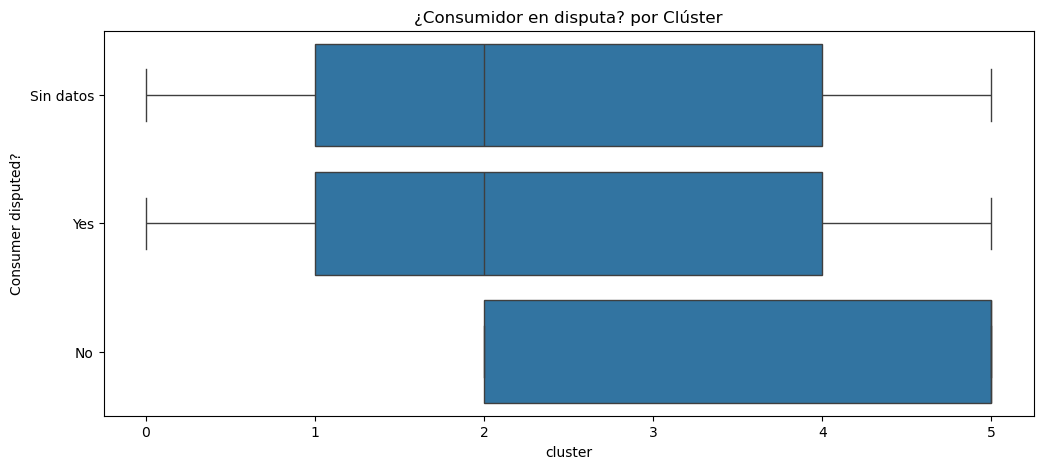

In [121]:
# 7. Análisis y evaluación de los clústeres
# Se puede visualizar la distribución de las variables por clúster
plt.figure(figsize=(12, 5))
sns.boxplot(x='cluster', y='Consumer disputed?', data=df_final)
plt.title('¿Consumidor en disputa? por Clúster')
plt.show()

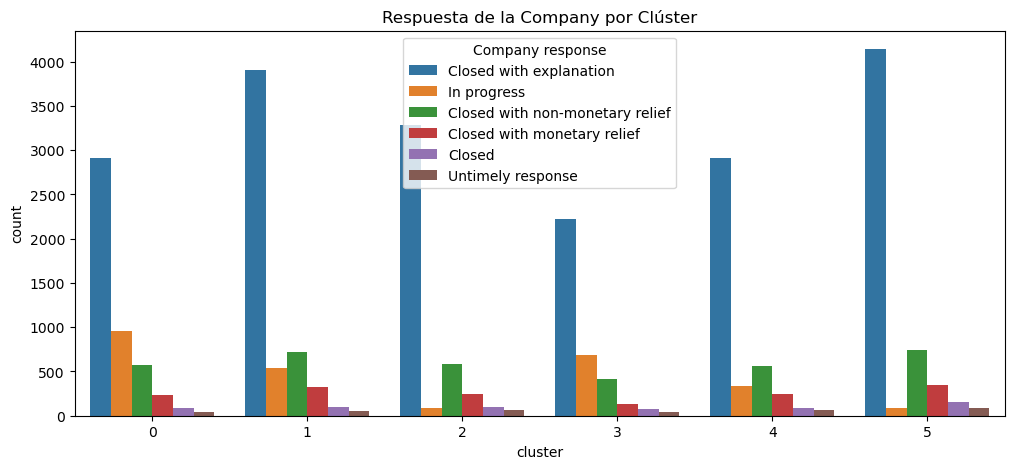

In [122]:
plt.figure(figsize=(12, 5))
sns.countplot(x='cluster', hue='Company response', data=df_final)
plt.title('Respuesta de la Company por Clúster')
plt.show()

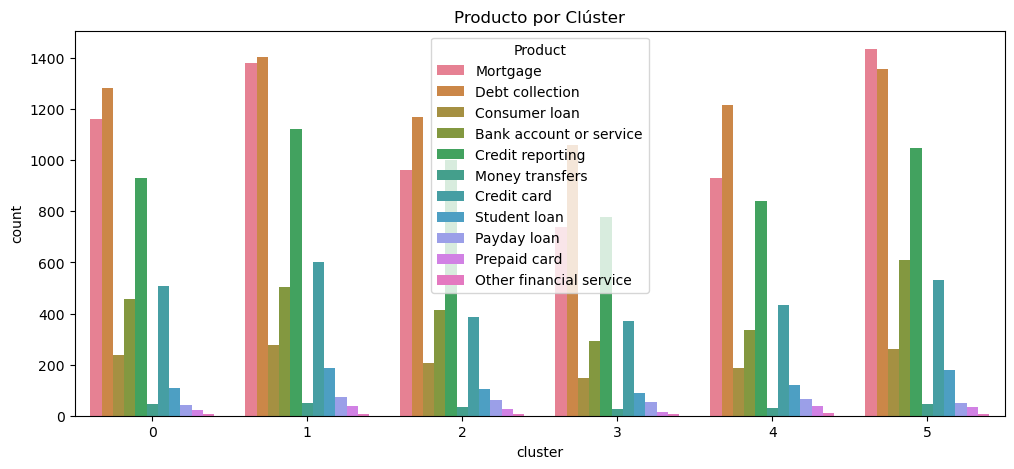

In [123]:
plt.figure(figsize=(12, 5))
sns.countplot(x='cluster', hue='Product', data=df_final)
plt.title('Producto por Clúster')
plt.show()

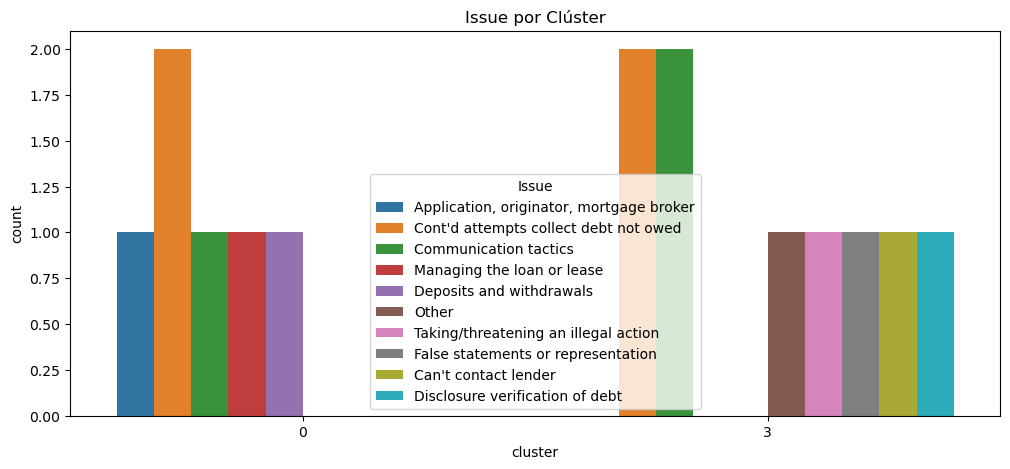

In [124]:
plt.figure(figsize=(12, 5))
sns.countplot(x='cluster', hue='Issue', data=df_final.head(15))
plt.title('Issue por Clúster')
plt.show()